# Car Accidents in USA 2022

## Motivation: 
By analyzing the geographical distribution and severity of accidents, we gain insight into potential hotspots and areas that require infrastructural or policy interventions. Secondly, understanding disparities between states in terms of accident numbers can guide us in identifying best practices and areas for improvement

## Abstract
This notebook is for studying Car Accidents in 2022. We provided a different notebook for the cleaning process. The notebook is called `00-Data-Cleaning.ipynb`. This notebook will give you an overview of the car accidents  throughout the US and then give you further information and analysis about the state that has the highest car accident rate per cappita, which is South Carolia. In the in-depth analysis, we will cover weather analysis, sunset/sunrise and prediction model to predict car accident's severity. 

## Data Sources: 
In this report, we will have 2 data sets: 
  1. `processed_us_car_accidents_2022.csv`: This is a processed dataset from US car accidents from [SOBHAN MOOSAVI](https://arxiv.org/abs/1906.05409). 
   The dataset is a countrywide car accident dataset that covers 49 states of the USA in 2022. This data records information  about the time of the accident, the accident location, weather related information (such as temperation, humidity, and wind-direction), and state's population
   
  2. `us-states.json`: GeoJSON data of US states from [Kaggle](https://www.kaggle.com/datasets/pompelmo/usa-states-geojson)
  This JSON file contains geographical data about 49 states of USA. The data contains information about each state coordinates, each state full's name and abbreviation. This data will allow us to undergo geospatial analysis on the data

## Overview Analysis 
> Code Creator: Trang Hoang/ Code Reviewer: 

We first are interested in seeing what the car accidents rate per capita looks like throughout the United States. This section is used to create visualizations and give some observations: 

- Number of Car Accidents Per Capita by States in 2022
- Top 5 States that have the highest number of car accidents per Capita

In [10]:
!pip install suntime

Defaulting to user installation because normal site-packages is not writeable


In [56]:
# Import libraries 
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import warnings
import zipfile
#Sunset/sunrise Libraries
import datetime
from suntime import Sun, SunTimeException
import re 

#Severity Predictions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import copy
from sklearn.utils import resample


current_wd=os.getcwd()


In [ ]:
# Extract the processed .zip data folder

# Path to the zip file
zip_path = f"{current_wd}/data/processed_us_car_accidents_2022.csv.zip"

# Directory to extract to
extract_to = f"{current_wd}/data/processed_us_car_accidents_2022.csv"
# Unzipping the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [12]:
# Load US Geo data
with open(f"{current_wd}/data/raw/us-states.json", encoding='utf8') as code:
    usa_states = json.load(code)


# Load car accidents data
df = pd.read_csv(f'{current_wd}/data/processed_us_car_accidents_2022.csv')
df.head()

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lattitude,Start_Longitude,Distance(mi),Description,State,...,Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,State_Abbrv,Population
0,0,A-512230,1,2022-09-08 05:49:30,2022-09-08 06:34:53,41.946796,-88.208092,0.00,Crash on CR-11 Army Trail Rd at IL-59.,IL,...,29.24,10.0,CALM,0.0,0.0,Fair,True,Night,IL,12582032
1,1,A-512231,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,0.00,Crash on CA-138 Pearblossom Hwy at 96th St.,CA,...,27.35,10.0,W,6.0,0.0,Fair,False,Night,CA,39029342
2,2,A-512232,1,2022-09-08 05:14:12,2022-09-08 07:38:17,37.542839,-77.441780,0.00,Crash on 2nd St Northbound at Franklin St.,VA,...,29.71,10.0,N,8.0,0.0,Mostly Cloudy,True,Night,VA,8683619
3,3,A-512233,1,2022-09-08 06:22:57,2022-09-08 06:52:42,40.896629,-81.178452,0.00,Crash on US-62 Atlantic Blvd Westbound after O...,OH,...,28.71,7.0,NNE,6.0,0.0,Mostly Cloudy,False,Night,OH,11756058
4,4,A-512234,2,2022-09-08 06:36:20,2022-09-08 07:05:58,41.409359,-81.644318,1.91,Crash on entry ramp to I-77 Northbound at Exit...,OH,...,29.37,7.0,SSE,3.0,0.0,Partly Cloudy,False,Night,OH,11756058


### Number of Car Accidents Per Capita by States in 2022m

In [13]:
# Generate the data for figures
# Count number of accidents 
accident_counts = df['State'].value_counts().reset_index()
accident_counts.columns = ['State', 'Counts']

# Extract population per state (assuming the population is the same for each state entry)
population_data = df[['State', 'Population']].drop_duplicates()

# Merge the counts with the population data
accidents_per_capita = accident_counts.merge(population_data, on='State')


# Calculate accidents per capita
accidents_per_capita['Accidents Per Capita'] = accidents_per_capita['Counts'] / accidents_per_capita['Population']

In [14]:
# Code Creator: Trang Hoang
# Code Revisor: 

# Creating the choropleth map using Plotly Express
fig = px.choropleth(
    data_frame=accidents_per_capita,  # Data containing the number of accidents
    geojson=usa_states,  # GeoJSON data for USA states
    color='Accidents Per Capita',  # Column representing the number of accidents
    locations='State',  # Column with state names or codes
    color_continuous_scale="Reds",  # Color scale for the choropleth map
    scope="usa",  # Focus the map on the USA
    labels={'Accidents Per Capita'}  # Label for the color bar
)

# Update the layout for better presentation
fig.update_geos(
    fitbounds="locations",  # Fit the geographical elements within the view
    visible=False  # Hide geographical elements borders
)
fig.update_layout(
    margin={"r":0, "t":40, "l":0, "b":0},  # Adjust margins to fit title
    title_text='Number of Car Accidents Per Capita by States in 2022',  # Adding a title
    title_x=0.5,  # Centering the title
    title_font=dict(size=20),  # Adjusting the font size of the title
    title_y=0.98,  # Adjusting the position of the title
    geo=dict(
        showland=True, 
        landcolor="white"
    )
)



**Observation**
- South Carolina(SC) has the highest number of accidents per capita: it stands out with the darkest shade, indicating it has the highest number of car accidents, approaching about 0.0159 number of accidents per capita

- Majority of high ratio numbers located in the middle east to south east side (e.g Virgina and Florid) and west/north west side (eg Montana). These regions have ratio about 0.006 to about 0.01

- Lower accident density is in the the middle of the US: The middle part of the US to South exhibits much lighter shade. This indicates a lower number of car accidents. The ratio is about 0.005 and lower

### Top 5 States that have the highest number of car accidents per Capita

C:\Users\tata\AppData\Local\Temp\ipykernel_23496\647521033.py:29: MatplotlibDeprecationWarning:

Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.



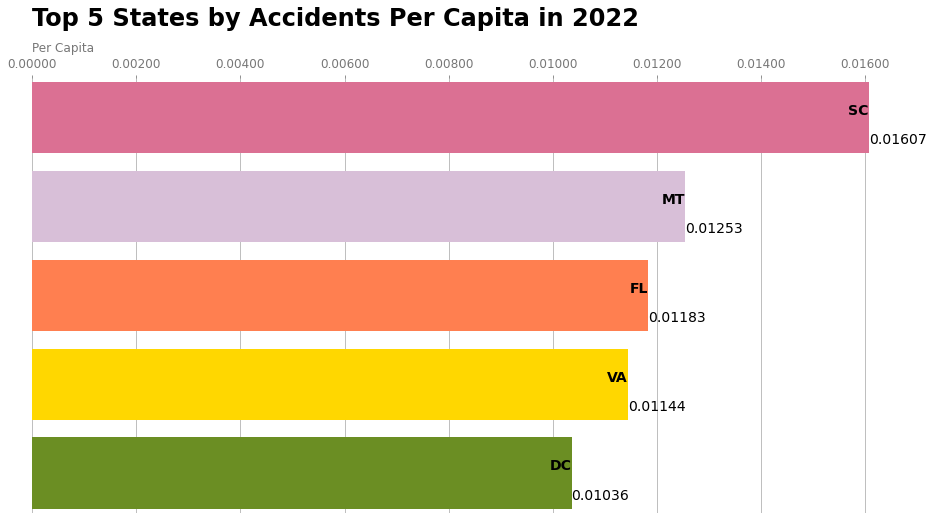

In [15]:
# Code Creator: Trang Hoang
# Code Revisor: 

# Find top 5 states that has highest accidents per capita

top_accidents_per_capita = accidents_per_capita.sort_values('Accidents Per Capita', ascending = False)[:5]
top_accidents_per_capita = top_accidents_per_capita[::-1]   # flip values from top to bottom
top_accidents_per_capita


# Create visualizations
# Define colors for the bars
colors = ['olivedrab', 'gold', 'coral', 'thistle', 'palevioletred']

# Creating the bar chart
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(top_accidents_per_capita['State'], top_accidents_per_capita['Accidents Per Capita'], color=colors)

# Adding text labels
for i, (value, name) in enumerate(zip(top_accidents_per_capita['Accidents Per Capita'], top_accidents_per_capita['State'])):
    ax.text(value, i, name, size=14, weight=600, ha='right', va='bottom')
    ax.text(value, i-.25, f'{value:.5f}', size=14, ha='left', va='center')

# Additional style settings
ax.text(0, 1.06, 'Per Capita', transform=ax.transAxes, size=12, color='#777777')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.5f}'))
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', colors='#777777', labelsize=12)
ax.set_yticks([])
ax.margins(0, 0.01)
ax.grid(which='major', axis='x', linestyle='-')
ax.set_axisbelow(True)
ax.text(0, 1.12, 'Top 5 States by Accidents Per Capita in 2022',
        transform=ax.transAxes, size=24, weight=600, ha='left')

plt.box(False)

# Save the figure
fig.savefig(f"{current_wd}/top_accidents_per_capita.png", dpi=300)

# Display the figure
plt.show()

**Observations:**
- State with highest accidents per capita: South Carolina (SC) has the highest accidents per capita among the top five states shown, with a value about 1.016. 

- The top 5 states that have the highest number of accidents per capita has the following order: SC, MT (Montana), FL (Florida), VA (Virginia), and DC (District of Columbia).

- The accidents per capita of the top 5 state has range from just above 0.010 to just below 0.016. The difference between the highest and lowest values in this top 5 list is less than 0.006.

## South Carolina Analysis: 

We will focus on only analyzing South Carolina as it is the highest car accident rate per capita. From the analysis, we might learn a little bit more about what factors cause car accidents to happen 

We first need to filter data for South Carolina 

In [37]:
df_sc = df[df['State']=='SC']
df_sc.head(5)

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lattitude,Start_Longitude,Distance(mi),Description,State,...,Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,State_Abbrv,Population
8,8,A-512238,1,2022-09-08 06:10:34,2022-09-08 06:40:17,33.771770,-79.719116,0.0,Crash on SC-512 Cade Rd at Five Bridges Rd.,SC,...,29.75,10.0,CALM,0.0,0.0,Cloudy,False,Night,SC,5282634
9,9,A-512239,1,2022-09-08 06:10:07,2022-09-08 06:39:51,33.863682,-81.238472,0.0,Crash on Boiling Springs Rd at Bluefield Rd.,SC,...,29.57,10.0,CALM,0.0,0.0,Fair,False,Night,SC,5282634
10,10,A-512240,1,2022-09-08 06:30:03,2022-09-08 07:29:44,34.133850,-80.744522,0.0,Crash on SC-47 White Pond Rd at SC-12 Fort Jac...,SC,...,29.52,10.0,NNE,8.0,0.0,Mostly Cloudy,False,Night,SC,5282634
36,36,A-512268,1,2022-09-08 05:52:24,2022-09-08 06:22:11,33.801682,-79.143051,0.0,Crash on Cates Bay Hwy at Dongola Hwy.,SC,...,29.77,10.0,CALM,0.0,0.0,Cloudy,False,Night,SC,5282634
37,37,A-512269,1,2022-09-08 06:24:54,2022-09-08 06:54:40,34.025124,-78.798973,0.0,Crash on SC-9 at Springfield Church Rd.,SC,...,29.72,10.0,NNE,3.0,0.0,Partly Cloudy,False,Night,SC,5282634



### Weather Anlysis 
> Code Creator: Susheel Srikanth / Code Reviewer: 

## Sunset/Sunrise analysis 

> Code Creator: Albert Hu/ Code Reviewer: 


Our group is curious about if there is some sort of relation between the sunset/sunrise and the number of car accidents. Our original hypothesis is depending on the driving direction, if individuals drive towards either sunset or sunset, it is more likely for car accident to happen



To automate the task of determining whether an accident occurred on a highway and its orientation (North, South, East, West), we can write a script that processes the descriptions. The script will use regular expressions to search for keywords indicating highway involvement and direction. If a highway is mentioned with a direction, it will return the respective orientation. If no highway or direction is indicated, it will return "Not_Highway".

In the US, highways are generally categorized into three types:

   -  Interstate Highways: Usually denoted with an 'I-' followed by a number, e.g., I-95, I-405, I-10.
   - U.S. Routes: Often signified by 'US-' followed by a number, e.g., US-1, US-66.
   - State Highways: These vary by state and can include state abbreviations or names, followed by a number, e.g., CA-1 for California, NY-27 for New York.



In [16]:
def analyze_description(description):
    # Regular expressions to find highway and direction mentions
    highway_pattern = re.compile(r'\b(I-\d+|US-\d+|[A-Z]{2}-\d+)\b', re.IGNORECASE)
    direction_pattern = re.compile(r'\b(Northbound|Southbound|Eastbound|Westbound|NB|SB|EB|WB|North|South|East|West|N|S|E|W)\b')

    # Capitalize the description to ensure case-insensitive matching for directions
    description = description.upper()

    # Search for patterns in the description
    highway_match = highway_pattern.search(description)
    direction_match = direction_pattern.search(description)

    # Determine if the incident is on a highway and its orientation
    if highway_match:
        if direction_match:
            # Extract the first word of the direction match as the orientation
            direction = direction_match.group(0).split()[0]
            return direction[0]  # Return only the first letter of the direction
        else:
            return "Not_Highway"
    else:
        return "Not_Highway"

In [38]:

accidents_data= df_sc.copy()
# Apply the analyze_description function to the description column
accidents_data['highway_direction'] = accidents_data['Description'].apply(analyze_description)



In [39]:
# show counts of highway_direction
print(accidents_data['highway_direction'].value_counts())

Not_Highway    63107
S               6018
N               5912
W               5139
E               4704
Name: highway_direction, dtype: int64


In [40]:
# sample random 10 data point on highway_direction and description
print(accidents_data[['highway_direction', 'Description']].sample(10))

        highway_direction                                        Description
410235        Not_Highway    Incident on SC-9 near US-17 Drive with caution.
567245        Not_Highway  Incident on CHARLOTTE HWY near CHARLOTTE HWY D...
1731135       Not_Highway  Incident on SC-160 near SLEEPY HOLLOW RD Drive...
621772        Not_Highway  Incident on MARSH RD near LYNHURST RD Drive wi...
227397        Not_Highway                    Accident on Dalton Dr at US-76.
869884                  W  Incident on I-26 WB near MM 134 Drive with cau...
900401                  N  Slow traffic on I-85 N from Aviation Dr/Exit 5...
281127        Not_Highway  Incident on SELLERS RD near SELLERS RD Drive w...
770054        Not_Highway  Incident on BOYDS MILL POND RD near SC-252 Dri...
1064556                 N      Incident on I-85 NB near MM 62 Expect delays.


In [41]:
# lets filter out the data that is not on highway
accidents_data = accidents_data[accidents_data['highway_direction'] != 'Not_Highway']

In [42]:
# define a function to calculate the sunrise and sunset time based on the latitude and longitude
def calculate_sunrise_sunset(latitude, longitude, date):
    # Initialize the Sun class for the given latitude and longitude
    sun = Sun(latitude, longitude)

    # Get sunrise and sunset for the given date
    sunrise = sun.get_local_sunrise_time(date)
    sunset = sun.get_local_sunset_time(date)

    # Return the tuple of sunrise and sunset
    return (sunrise, sunset)

In [43]:
# seprate the date and time from the start_time column
accidents_data['date'] = pd.to_datetime(accidents_data['Start_Time']).dt.date
accidents_data['time'] = pd.to_datetime(accidents_data['Start_Time']).dt.time

In [44]:
# calculate the sunrise and sunset time for each data point
accidents_data['sunrise'], accidents_data['sunset'] = zip(*accidents_data.apply(lambda x: calculate_sunrise_sunset(x['Start_Lattitude'], x['Start_Longitude'], x['date']), axis=1))

In [45]:
# show the first 5 rows of the data of their accident time, sunrise and sunset time, direction, severity and description
print(accidents_data[['time', 'sunrise', 'sunset', 'highway_direction', 'Severity', 'Description']].head())

           time                   sunrise                    sunset  \
542    08:47:16 2022-09-08 06:04:00-05:00 2022-09-08 18:41:00-05:00   
771    07:04:15 2022-09-08 06:04:00-05:00 2022-09-08 18:41:00-05:00   
6371   19:22:21 2022-09-01 05:55:00-05:00 2022-09-01 18:45:00-05:00   
6617   14:35:40 2022-09-01 06:04:00-05:00 2022-09-01 18:57:00-05:00   
10207  15:56:37 2022-08-29 06:00:00-05:00 2022-08-28 19:00:00-05:00   

      highway_direction  Severity  \
542                   S         1   
771                   S         1   
6371                  W         3   
6617                  E         1   
10207                 S         2   

                                             Description  
542    Crash on US-321 Bufords Bridge Hwy at US-301 B...  
771    Crash on US-321 Bufords Bridge Hwy at US-301 B...  
6371   Exit ramp from I-26 Southbound at Exits 213 21...  
6617          Crash on SC-81 at SC-108 Wilton E Hall Rd.  
10207  Left lane blocked due to crash on SC-146 Woodr..

In [46]:
# define a function to filter out the accident that is +/- 1 hour from sunrise and sunset time
def filter_accidents(row):
    # Get the accident time, sunrise time, and sunset time
    accident_time = row['time']
    sunrise_time = row['sunrise'].time()
    sunset_time = row['sunset'].time()

    # Calculate time difference between the accident and sunrise
    sun_rise_diff = abs(datetime.datetime.combine(datetime.date.min, accident_time) - datetime.datetime.combine(datetime.date.min, sunrise_time))
    sun_set_diff = abs(datetime.datetime.combine(datetime.date.min, accident_time) - datetime.datetime.combine(datetime.date.min, sunset_time))
    
    # Check if the accident time is within +/- 1 hour of sunrise or sunset time
    if sun_rise_diff <= datetime.timedelta(hours=1):
        return "Sunrise"
    elif sun_set_diff <= datetime.timedelta(hours=1):
        return "Sunset"
    elif (accident_time > sunrise_time) & (accident_time < sunset_time):
        return "Daytime"
    else:
        return "Nighttime"
   

In [47]:
# filter out the data that is not during sunrise, sunset or day time
accidents_data['daytime'] = [filter_accidents(row) for index, row in accidents_data.iterrows()]

Here are some potential ways to compare the directions and sunrise_sunset time might affect the accident severity:

In [48]:
# show the count of the daytime column
print(accidents_data['daytime'].value_counts())

Daytime      14162
Nighttime     3766
Sunset        2618
Sunrise       1227
Name: daytime, dtype: int64


In [49]:
# check the correlation between daytime, highway_direction
print(accidents_data.groupby(['daytime', 'highway_direction']).size())

daytime    highway_direction
Daytime    E                    3020
           N                    3855
           S                    3869
           W                    3418
Nighttime  E                     741
           N                    1003
           S                    1116
           W                     906
Sunrise    E                     450
           N                     290
           S                     352
           W                     135
Sunset     E                     493
           N                     764
           S                     681
           W                     680
dtype: int64


In [50]:
# check the correlation between daytime and highway_direction(combine the direction to NS, EW)
accidents_data['highway_direction_combine'] = accidents_data['highway_direction'].replace({'N': 'NS', 'S': 'NS', 'E': 'EW', 'W': 'EW'})
print(accidents_data.groupby(['daytime', 'highway_direction_combine']).size())

daytime    highway_direction_combine
Daytime    EW                           6438
           NS                           7724
Nighttime  EW                           1647
           NS                           2119
Sunrise    EW                            585
           NS                            642
Sunset     EW                           1173
           NS                           1445
dtype: int64


In [51]:
# check the percentage of highway_direction_combine vs total accident count for each daytime
print(accidents_data.groupby(['daytime', 'highway_direction_combine']).size()/accidents_data.groupby(['daytime']).size())

daytime    highway_direction_combine
Daytime    EW                           0.454597
           NS                           0.545403
Nighttime  EW                           0.437334
           NS                           0.562666
Sunrise    EW                           0.476773
           NS                           0.523227
Sunset     EW                           0.448052
           NS                           0.551948
dtype: float64


## Severity Prediction
> Code Creator: Murad/ Code Reviewer: 

<Figure size 1080x432 with 0 Axes>

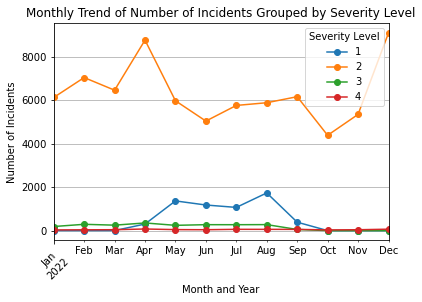

In [52]:
df_sc_severity = df_sc.copy()
# Extracting month and year from the Start_Time for grouping
df_sc_severity['Start_Time'] = pd.to_datetime(df['Start_Time'])
df_sc_severity['Month_Year'] = df_sc_severity['Start_Time'].dt.to_period('M')

# Grouping data by month and year, and then by severity, and counting incidents
monthly_incidents_severity = df_sc_severity.groupby(['Month_Year', 'Severity']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(15, 6))
monthly_incidents_severity.plot(kind='line', marker='o')

# Formatting the plot
plt.title('Monthly Trend of Number of Incidents Grouped by Severity Level')
plt.xlabel('Month and Year')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(title='Severity Level')
plt.grid(True)

# Show the plot
plt.show()

In [53]:
df_sc_severity['Severity'].value_counts()

2    76056
1     6043
3     2198
4      583
Name: Severity, dtype: int64



We observed that there were only 579 instances of severity level 4 in our dataset, which presented a significant challenge in training our model effectively. Initially, we attempted to address this by sampling 500 instances from each severity level, including severity level 4. However, this approach did not yield satisfactory results, as the model still struggled to accurately predict severity level 4 incidents, achieving only around 15% accuracy for this category.

To further explore this issue, we adjusted our approach by increasing the sample size for the other severity levels to 2000 each, while maintaining 500 samples for severity level 4. Despite this adjustment, the model's performance in predicting severity level 4 incidents did not improve significantly, indicating that the limited number of severity level 4 samples was insufficient for the model to learn and generalize effectively.

Given these outcomes, we decided to exclude severity level 4 from our analysis. This decision was based on several considerations:

The low occurrence of severity level 4 incidents in the dataset led to an imbalance that the model could not overcome, even with adjusted sampling strategies. The limited data for severity level 4 did not provide enough variability and patterns for the model to learn from, resulting in poor predictive accuracy. Focusing on the more frequent severity levels allowed us to utilize a larger, more representative sample for those categories, potentially improving the model's overall performance. By removing the least represented severity level, we aimed to reduce the model's complexity and improve its ability to predict the more common severity levels accurately. This approach also aligns with practical considerations, where the focus is often on predicting and understanding more frequent events that have a higher likelihood of occurrence. In summary, the exclusion of severity level 4 from our model was a strategic decision to enhance the model's performance and reliability, given the constraints posed by the available data.


In [57]:
# Set a random seed for reproducibility
random_seed = 42

n_samples = 2000

# Separate the dataset into subsets based on severity levels
severity_1 = df_sc_severity[df_sc_severity['Severity'] == 1]
severity_2 = df_sc_severity[df_sc_severity['Severity'] == 2]
severity_3 = df_sc_severity[df_sc_severity['Severity'] == 3]
# didn't include Severity level 4
# severity_4 = df[df['Severity'] == 4]

# Resample each subset
severity_1_sampled = resample(severity_1, replace=False, n_samples=n_samples, random_state=random_seed)
severity_2_sampled = resample(severity_2, replace=False, n_samples=n_samples, random_state=random_seed)
severity_3_sampled = resample(severity_3, replace=False, n_samples=n_samples, random_state=random_seed)
# severity_4_sampled = resample(severity_4, replace=False,  n_samples=n_samples, random_state=random_seed)  


# Combine the samples into one dataframe
balanced_data = pd.concat([severity_1_sampled, severity_2_sampled, severity_3_sampled])

# Shuffle the combined dataset
balanced_data = balanced_data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

balanced_data.head()

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lattitude,Start_Longitude,Distance(mi),Description,State,...,Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Traffic_Signal,Sunrise_Sunset,State_Abbrv,Population,Month_Year
0,102417,A-622937,1,2022-05-13 17:38:25,2022-05-13 18:38:15,35.010811,-81.956367,0.000,Crash on Sloane Garden Rd at SC-9.,SC,...,10.0,E,3.0,0.0,Light Drizzle,False,Day,SC,5282634,2022-05
1,1682780,A-5372848,2,2022-11-02 02:06:05,2022-11-02 03:34:04,33.606958,-79.015084,0.527,Incident on US-17 near US-17 Drive with caution.,SC,...,10.0,NW,5.0,0.0,Fair,False,Night,SC,5282634,2022-11
2,85225,A-604181,1,2022-06-01 04:46:47,2022-06-01 05:31:55,34.580139,-82.648392,0.000,Crash on Concord Rd at Quail Run.,SC,...,10.0,CALM,0.0,0.0,Fair,False,Night,SC,5282634,2022-06
3,961482,A-4541031,2,2022-04-28 17:50:29,2022-04-28 19:58:25.000000000,34.888862,-82.373846,0.101,Slow traffic on SC-291 from Piney Mountain Rd ...,SC,...,10.0,SSW,9.0,0.0,Fair,False,Day,SC,5282634,2022-04
4,68459,A-585912,3,2022-06-22 13:13:26,2022-06-22 14:28:07,32.881279,-79.934601,0.000,Right lane blocked due to crash on I-526 Mark ...,SC,...,9.0,NW,8.0,0.0,Fair,False,Day,SC,5282634,2022-06


In [58]:
# creating 
df_sample = copy.deepcopy(balanced_data)

# Data Preparation
features = ['Temperature(F)', 'Traffic_Signal', 'Distance(mi)', 'Precipitation(in)']
target = 'Severity'
df_sample['Traffic_Signal'] = df_sample['Traffic_Signal'].astype(int)  # Convert 'Traffic_Signal' to numerical

# Extracting the features and target
X = df_sample[features]
y = df_sample[target]

# Handling missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
# test size was taken 30%
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=15)

# Training the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Generating the confusion matrix for individual accuracies
cm = confusion_matrix(y_test, y_pred)
individual_accuracies = cm.diagonal() / cm.sum(axis=1)
individual_accuracies_dict = {f"Severity {i+1} Accuracy": acc for i, acc in enumerate(individual_accuracies)}

# Displaying results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Individual Accuracies for Each Severity Level:", individual_accuracies_dict)

Accuracy: 0.6655555555555556
Classification Report:
               precision    recall  f1-score   support

           1       0.59      0.72      0.65       573
           2       0.89      0.78      0.83       625
           3       0.54      0.49      0.51       602

    accuracy                           0.67      1800
   macro avg       0.67      0.67      0.66      1800
weighted avg       0.68      0.67      0.67      1800

Individual Accuracies for Each Severity Level: {'Severity 1 Accuracy': 0.7242582897033158, 'Severity 2 Accuracy': 0.7824, 'Severity 3 Accuracy': 0.4883720930232558}


<Figure size 864x576 with 0 Axes>

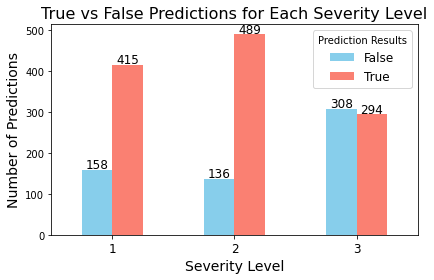

In [59]:
# Create a DataFrame for the test set with actual and predicted severity
test_results_df = pd.DataFrame({'Actual_Severity': y_test, 'Predicted_Severity': y_pred})
test_results_df['Correct_Prediction'] = test_results_df['Actual_Severity'] == test_results_df['Predicted_Severity']

# Grouping by Actual Severity and whether the prediction was correct
grouped_data = test_results_df.groupby(['Actual_Severity', 'Correct_Prediction']).size().unstack(fill_value=0)


plt.figure(figsize=(12, 8))  # figure size
grouped_bar = grouped_data.plot(kind='bar', stacked=False, color=['skyblue', 'salmon'])

plt.title('True vs False Predictions for Each Severity Level', fontsize=16)  #  title font size
plt.xlabel('Severity Level', fontsize=14)  # Increased x-axis label font size
plt.ylabel('Number of Predictions', fontsize=14)  # Increased y-axis label font size
plt.xticks(rotation=0, fontsize=12)  # Increased x-axis ticks font size
plt.legend(['False', 'True'], title='Prediction Results', fontsize=12)  # Increased legend font size

# Adding annotations on each bar with reduced gap
for p in grouped_bar.patches:
    grouped_bar.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=12)  # Increased annotation font size

plt.tight_layout()

# Save plot with high resolution
plt.savefig('plot_high_res.png', dpi=600)  # Save as high-resolution PNG

# Show plot
plt.show()